In [1]:
import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from shapely.geometry import Polygon

import bento as bt

mpl.style.use("dark_background")


In [28]:
adata = bt.ds.load_dataset('seqfish')

In [29]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)


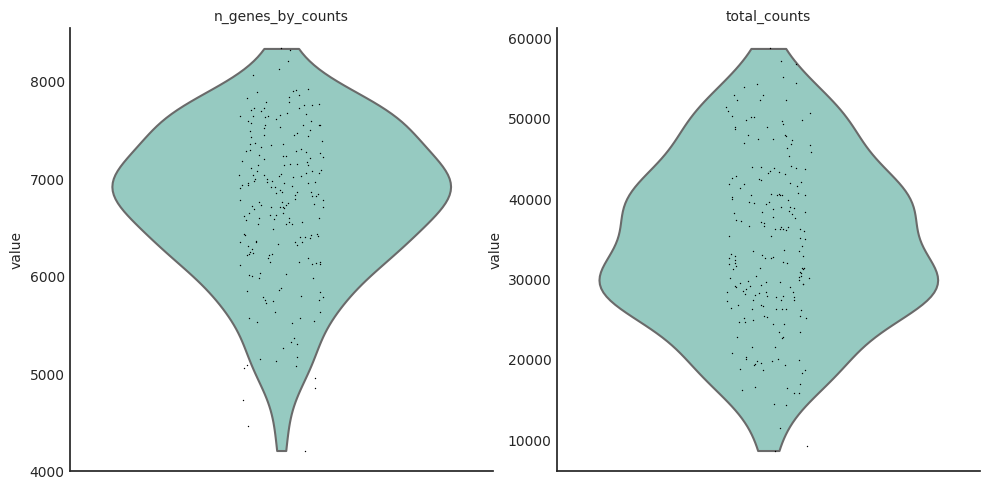

In [30]:
mpl.style.use("seaborn-v0_8-white")
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    multi_panel=True,
)


In [31]:
bt.tl.analyze_shapes(adata, shape_names=["cell"], feature_names="area")


  0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'n_genes_by_counts')

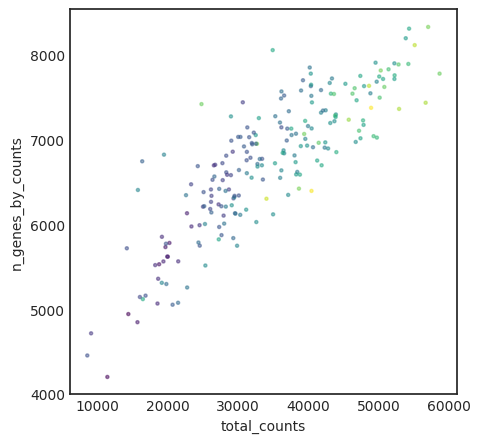

In [32]:
plt.figure(figsize=(5, 5))
plt.scatter(
    x=adata.obs["total_counts"],
    y=adata.obs["n_genes_by_counts"],
    c=adata.obs["cell_area"],
    s=5,
    alpha=0.5,
    cmap="viridis",
)
plt.xlabel("total_counts")
plt.ylabel("n_genes_by_counts")


In [33]:
adata.layers['log'] = sc.pp.log1p(adata.X)

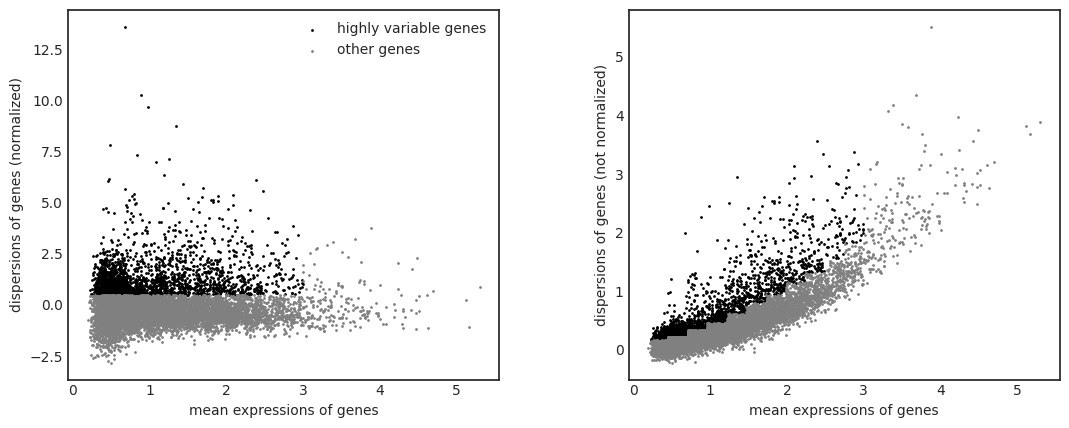

In [34]:
sc.pp.highly_variable_genes(adata, layer='log')
sc.pl.highly_variable_genes(adata)

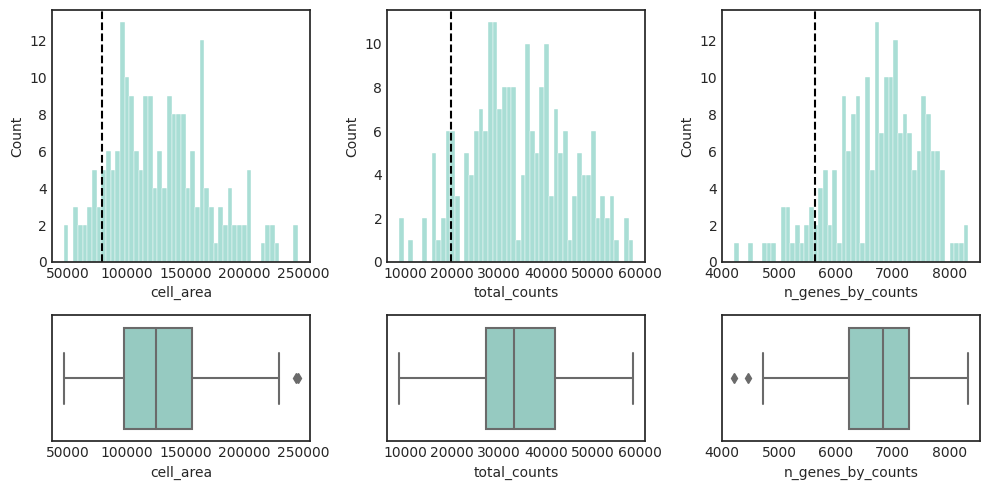

In [35]:
# Plot histogram of cell area, total counts, and n_genes_by_counts in subplots. Draw boxplots underneath each histogram.
fig, axes = plt.subplots(2, 3, figsize=(10, 5), gridspec_kw={"height_ratios": [2, 1]})

for i, (feature, ax) in enumerate(
    zip(["cell_area", "total_counts", "n_genes_by_counts"], axes[0])
):
    sns.histplot(adata.obs[feature], ax=ax, bins=50)
    ax.axvline(np.quantile(adata.obs[feature], 0.10), c="k", ls="--")

for i, (feature, ax) in enumerate(
    zip(["cell_area", "total_counts", "n_genes_by_counts"], axes[1])
):
    sns.boxplot(x=adata.obs[feature], ax=ax, orient="h")
    ax.set_xlabel(feature)

plt.tight_layout()


In [36]:
min_area = np.quantile(adata.obs["cell_area"], 0.10)
min_cell_counts = np.quantile(adata.obs["total_counts"], 0.10)
min_gene_counts = np.quantile(adata.obs["n_genes_by_counts"], 0.10)

adata = adata[adata.obs["cell_area"] > min_area]
adata = adata[adata.obs["total_counts"] > min_cell_counts]
adata = adata[adata.obs["n_genes_by_counts"] > min_gene_counts]
adata

View of AnnData object with n_obs × n_vars = 174 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'total_counts', 'cell_area'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'points', 'hvg'
    layers: 'spliced', 'unspliced', 'log'

In [37]:
adata = adata[adata.obs["nucleus_shape"].apply(lambda s: isinstance(s, Polygon))]
bt.sync(adata)


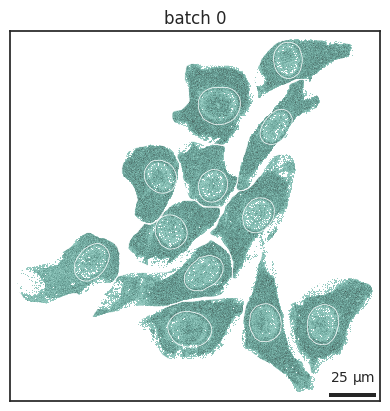

In [38]:
bt.pl.density(adata, binwidth=5)


In [58]:
importlib.reload(bt.tl._neighborhoods)
importlib.reload(bt.tl._flux)
importlib.reload(bt.tl)
importlib.reload(bt)

radii = [0.5]
dx = 0.1
res = 0.05
bt.settings.log.setLevel("WARNING")

adatas = []
for r in radii:
    adata_r = bt.tl.flux(adata, radius=r, train_size=0.5, n_components=100, res=res, use_highly_variable=False, copy=True)
    adatas.append(adata_r)


156


  0%|          | 0/156 [00:00<?, ?it/s]

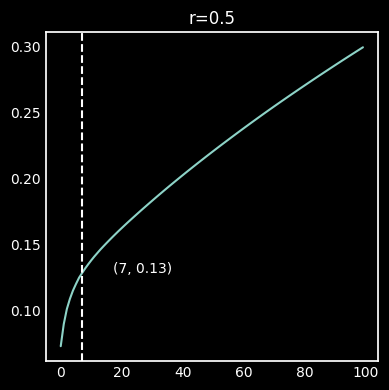

In [61]:
with mpl.style.context("dark_background"):
    fig, axes = plt.subplots(1, len(adatas), figsize=(4 * len(adatas), 4))
    axes = [axes] if len(adatas) == 1 else axes
    for a, r, ax in zip(adatas, radii, axes):
        ax.plot(np.cumsum(a.uns["flux_variance_ratio"]))
        elbow = a.uns["flux_n_components"]
        cumvar = np.sum(a.uns["flux_variance_ratio"][: elbow + 1])
        ax.axvline(elbow, ls="--")
        ax.text(elbow + 10, cumvar, f"({elbow}, {cumvar:.2f})")
        ax.set_title(f"r={r}")

    plt.tight_layout()


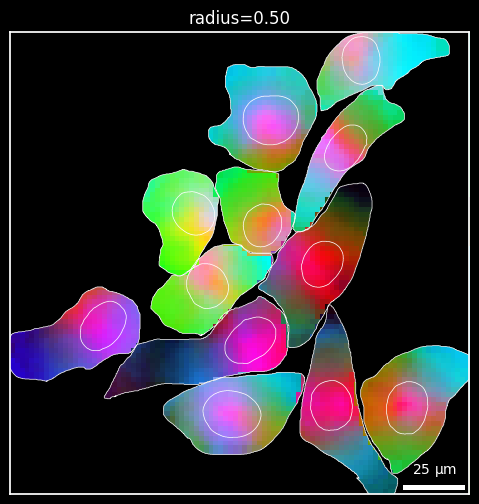

In [64]:
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)
importlib.reload(bt)

mpl.style.use("dark_background")

fig, axes = plt.subplots(1, len(adatas), figsize=(6 * len(adatas), 6))
axes = [axes] if len(adatas) == 1 else axes

for a, ax, r in zip(adatas, axes, radii):
    bt.pl.flux(a, res=res, dims=[0, 1, 2], alpha=False, ax=ax, dx=dx)
    ax.set_title(f"radius={r:.2f}")
    # break


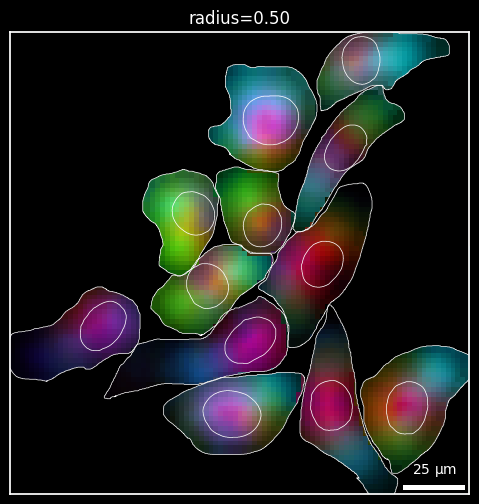

In [65]:
importlib.reload(bt)
importlib.reload(bt.pl)

mpl.style.use("dark_background")

fig, axes = plt.subplots(1, len(adatas), figsize=(6 * len(adatas), 6))
axes = [axes] if len(adatas) == 1 else axes

for a, ax, r in zip(adatas, axes, radii):
    bt.pl.flux(a, res=res, dims=[0, 1, 2], alpha=True, ax=ax, dx=dx)
    ax.set_title(f"radius={r:.2f}")
    # break


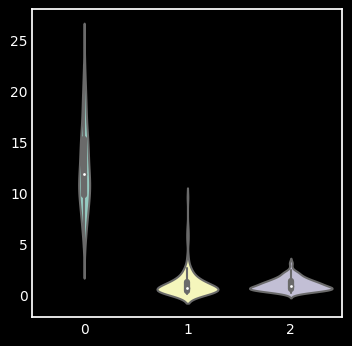

In [66]:
fig, axes = plt.subplots(1, len(adatas), figsize=(4 * len(adatas), 4))
axes = [axes] if len(adatas) == 1 else axes

for a, ax in zip(adatas, axes):
    cell_flux = pd.DataFrame(a.uns["flux_embed"][:, :3]).groupby(
        a.uns["cell_raster"]["cell"]
    )
    intra_var = cell_flux.var()
    inter_var = cell_flux.mean().var()

    sns.violinplot(data=intra_var / inter_var, ax=ax)


In [68]:
adata_main = adatas[0]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

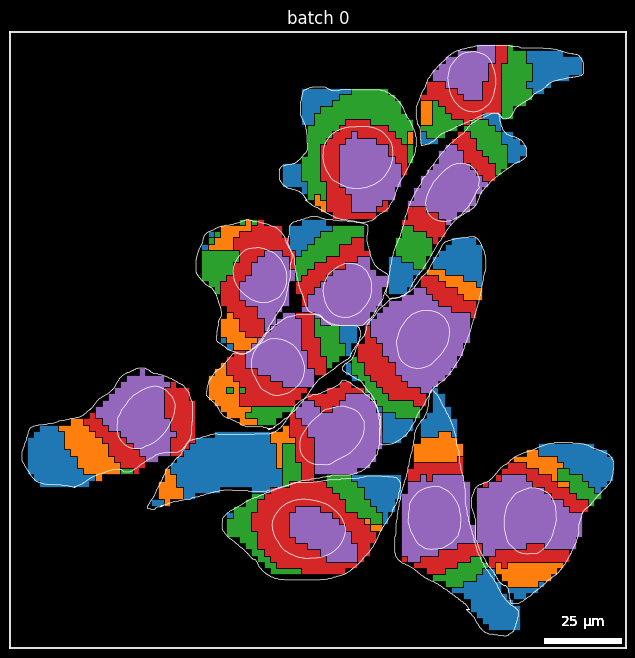

In [69]:
importlib.reload(bt.tl._flux)
importlib.reload(bt.tl)
importlib.reload(bt)

bt.tl.fluxmap(adata_main, n_clusters=5, n_components=5, min_points=50, res=res, train_size=1)

fig = plt.figure(figsize=(8, 8))
bt.pl.fluxmap(adata_main, dx=dx)


In [70]:
pc_weights = pd.DataFrame(
    adatas[1].uns["flux_sv"][:3],
    index=[f"PC{i}" for i in range(3)],
    columns=adata_main.uns["flux_genes"],
).T

import decoupler as dc

genesets = bt.tl.load_gene_sets("fazal2019")
genesets = genesets.pivot(index="source", columns="target", values="weight").T.fillna(0)
genesets.head()

common_genes = set(genesets.index).intersection(set(pc_weights.index))

all_df = pd.concat([pc_weights.loc[common_genes], genesets.loc[common_genes]], axis=1)

pc2genesets = all_df.corr(method="spearman").loc[pc_weights.columns, genesets.columns]
sns.clustermap(pc2genesets, cmap="RdBu_r", center=0, figsize=(4, 4), row_cluster=False)


IndexError: list index out of range

<Axes: >

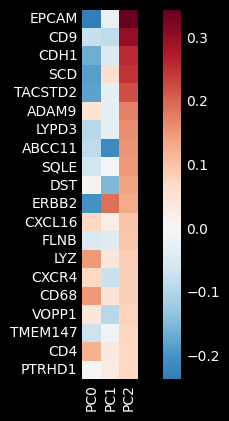

In [ ]:
sns.heatmap(
    pc_weights.sort_values("PC2", ascending=False).head(20),
    cmap="RdBu_r",
    center=0,
    square=True,
)
